In [1]:
##Trip Analysis
!Pip install Pyspark
!pip install faker
!pip install kaleido

/bin/bash: line 1: Pip: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.3 MB/s eta 0:00:00


In [2]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, TimestampType
import numpy as np
from faker import Faker
from datetime import timedelta
import random
spark = SparkSession.builder.appName("TripDataGeneration").getOrCreate()
fake = Faker()

In [3]:
schema = StructType([
    StructField("TripID", IntegerType(), False),
    StructField("StartTime", TimestampType(), False),
    StructField("EndTime", TimestampType(), False),
    StructField("Distance", FloatType(), False),
    StructField("Fare", FloatType(), False)
])

In [8]:
num_records = 1_000_000
rdd = spark.sparkContext.parallelize(range(num_records)).map(
    lambda i: (
        i,
        fake.date_time_between(start_date="-2d", end_date="now"),
        round(random.uniform(1, 50), 2),
        round(random.uniform(5, 80), 2)  #
    )
)
def calculate_fare(distance):
    base_fare = 30
    rate_per_km = 10
    return round(base_fare + (distance * rate_per_km), 2)

rdd = rdd.map(lambda x: (
    x[0],
    x[1],
    x[1] + timedelta(minutes=(x[2] / x[3]) * 60),
    x[2],
    calculate_fare(x[2])
))


df = spark.createDataFrame(rdd, schema=schema)
df.show(5)


+------+--------------------+--------------------+--------+-----+
|TripID|           StartTime|             EndTime|Distance| Fare|
+------+--------------------+--------------------+--------+-----+
|     0|2025-03-08 02:49:...|2025-03-08 03:05:...|   12.77|157.7|
|     1|2025-03-08 08:08:...|2025-03-08 11:07:...|    40.8|438.0|
|     2|2025-03-08 01:27:...|2025-03-08 02:06:...|   18.51|215.1|
|     3|2025-03-08 19:09:...|2025-03-08 19:34:...|     7.5|105.0|
|     4|2025-03-07 22:08:...|2025-03-08 00:03:...|   36.86|398.6|
+------+--------------------+--------------------+--------+-----+
only showing top 5 rows



In [9]:

from pyspark.sql import functions as F

In [10]:
df = df.withColumn("TripDuration",
                   (F.col("EndTime").cast("long") - F.col("StartTime").cast("long")) / 60)

df.show(5)

+------+--------------------+--------------------+--------+-----+------------------+
|TripID|           StartTime|             EndTime|Distance| Fare|      TripDuration|
+------+--------------------+--------------------+--------+-----+------------------+
|     0|2025-03-08 02:50:...|2025-03-08 03:02:...|    5.44| 84.4|11.933333333333334|
|     1|2025-03-08 08:09:...|2025-03-08 09:05:...|   45.38|483.8| 55.56666666666667|
|     2|2025-03-08 01:28:...|2025-03-08 02:08:...|   19.63|226.3| 39.68333333333333|
|     3|2025-03-08 19:10:...|2025-03-08 19:34:...|   26.53|295.3|24.066666666666666|
|     4|2025-03-07 22:09:...|2025-03-08 05:48:...|   45.92|489.2|             459.2|
+------+--------------------+--------------------+--------+-----+------------------+
only showing top 5 rows



In [11]:
LongestByDistance = df.select('TripID', 'Distance', 'TripDuration').orderBy(F.col('Distance').desc()).limit(3)
LongestByDistance.show()



+------+--------+------------------+
|TripID|Distance|      TripDuration|
+------+--------+------------------+
| 13259|    50.0| 56.88333333333333|
|503214|    50.0|146.91666666666666|
| 72470|    50.0|39.833333333333336|
+------+--------+------------------+



In [12]:
trips_per_hour = df.withColumn("HourOfDay", F.hour(F.col("StartTime"))) .groupBy("HourOfDay") .agg(F.count("TripID").alias("TotalTrips"))
trips_per_hour.show(5)



+---------+----------+
|HourOfDay|TotalTrips|
+---------+----------+
|       12|     41665|
|       22|     41913|
|        1|     41637|
|       13|     41593|
|       16|     41669|
+---------+----------+
only showing top 5 rows



In [13]:
import plotly.express as px
import plotly.graph_objects as go
trips_per_hour_pd = trips_per_hour.toPandas()
trips_per_hour_pd = trips_per_hour_pd.sort_values(by="HourOfDay")
trips_per_hour_pd = trips_per_hour_pd.groupby("HourOfDay", as_index=False).sum()
trips_per_hour_pd["HourOfDay"] = trips_per_hour_pd["HourOfDay"].astype(int)
fig1 = px.line(trips_per_hour_pd,x="HourOfDay",y="TotalTrips",  title="Trips Per Hour (Line Chart with Peaks & Lows)",labels={"HourOfDay": "Hour of Day", "TotalTrips": "Total Number of Trips"},
               markers=True,color_discrete_sequence=["blue"])
max_point = trips_per_hour_pd.loc[trips_per_hour_pd["TotalTrips"].idxmax()]
min_point = trips_per_hour_pd.loc[trips_per_hour_pd["TotalTrips"].idxmin()]
fig1.add_trace(go.Scatter(x=[max_point["HourOfDay"]],y=[max_point["TotalTrips"]],mode='markers+text',text=["Peak"],textposition="top center",marker=dict(color='red', size=12, symbol='star')
))

fig1.add_trace(go.Scatter( x=[min_point["HourOfDay"]], y=[min_point["TotalTrips"]], mode='markers+text', text=["Low"], textposition="bottom center", marker=dict(color='green', size=12, symbol='diamond')
))


fig1.show()



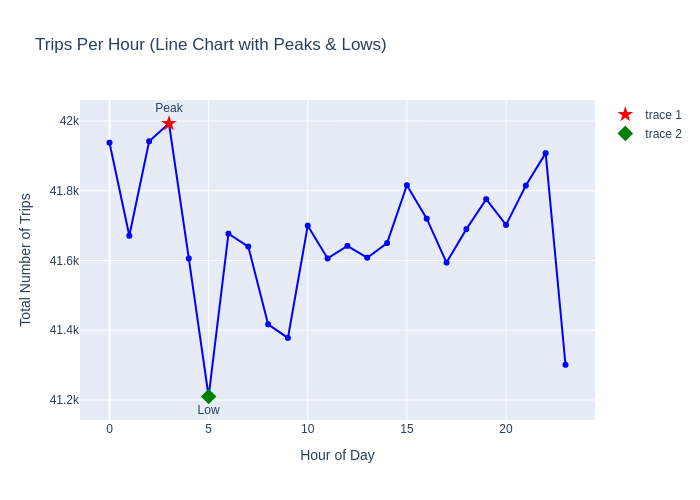

In [14]:
fig1.write_image("trips_per_hour_line_chart.png")

from IPython.display import display, Image
display(Image(filename="trips_per_hour_line_chart.png"))




